In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,}'.format
from pandas.plotting import autocorrelation_plot
from math import sqrt
import researchpy as rp
import scipy as sp
from scipy import stats
import scipy.signal
from scipy.signal import fftconvolve, convolve
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import random as ran
from pprint import pprint

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn import datasets
from sklearn import set_config
set_config(display='diagram')
from xgboost import XGBClassifier, XGBRegressor
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
#from textacy.preprocess import preprocess_text

from gensim import corpora, models, matutils
from collections import defaultdict, Counter

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf

import patsy
from itertools import combinations

import graphviz
import json
import requests
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from time import sleep
import re
import twitter

In [2]:
%matplotlib inline
#plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Build and document a working model, prototype, recommendation, or solution

Note: The new Statcast metrics are available beginning from the 2015 baseball season to the current season. I downloaded the 2015-2017 baseball season data for all teams which will be used in the data modeling.

## [pybaseball](https://github.com/jldbc/pybaseball) 
Pull current and historical baseball statistics using Python (Statcast, Baseball Reference, FanGraphs)

`pybaseball` is a Python package for baseball data analysis. This package scrapes Baseball Reference, Baseball Savant, and FanGraphs so you don't have to. The package retrieves statcast data, pitching stats, batting stats, division standings/team records, awards data, and more. Data is available at the individual pitch level, as well as aggregated at the season level and over custom time periods. See the [docs](https://github.com/jldbc/pybaseball/tree/master/docs) for a comprehensive list of data acquisition functions.

**Statcast**

The statcast function retrieves pitch-level statcast data for a given date or range or dates.

statcast(start_dt=[yesterday's date], end_dt=None, team=None)

In [3]:
# Pull advanced metrics from Major League Baseball's Statcast system
#from pybaseball import statcast

# Look up a player's MLBAM, Retrosheet, FanGraphs, and Baseball Reference ID by name
#from pybaseball import playerid_lookup

### Reading a File

In [4]:
# Create data path variable for loading data
data_path = '/Users/yangweichle/Documents/Employment/TRAINING/DATA SCIENCE/PROJECTS/PredictingBaseballStatistics/Datasets/'

In [5]:
# Read file into DataFrame
# Note: header=0 disables the header from the file
all_MLB_teams2015_2017 = pd.read_csv(data_path + 'all_MLB_teams2015_2017.csv', header=0) # Comma-separated values file

### Examine the DataFrame

In [6]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017.shape[0], all_MLB_teams2015_2017.shape[1]))

Rows: 2139920, Cols: 91


In [7]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist
#       show_counts: whether to show the non-null counts
all_MLB_teams2015_2017.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139920 entries, 0 to 2139919
Data columns (total 91 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   Unnamed: 0                       2139920 non-null  int64  
 1   index                            2139920 non-null  int64  
 2   pitch_type                       2136106 non-null  object 
 3   game_date                        2139920 non-null  object 
 4   release_speed                    2137415 non-null  float64
 5   release_pos_x                    2118565 non-null  float64
 6   release_pos_z                    2118565 non-null  float64
 7   player_name                      2139920 non-null  object 
 8   batter                           2139920 non-null  float64
 9   pitcher                          2139920 non-null  float64
 10  events                           553868 non-null   object 
 11  description                      2139920 non-null 

In [8]:
# Column names (which is "an index")
all_MLB_teams2015_2017.columns

Index(['Unnamed: 0', 'index', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       'events', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'pos2_person_id', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pos1_person_id',
       'pos2_person_id.1', 'pos3_person_id', 'pos4_person_id',
       'pos5_person_id', 'pos6_person_id', 'pos7_person

In [9]:
# Sort a DataFrame by multiple columns
# Note: ascending: sort ascending vs. descending; ascending=True is default
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=True, inplace=True)

In [10]:
# Print the first 5 rows and the last 5 rows of the DataFrame
all_MLB_teams2015_2017.head().append(all_MLB_teams2015_2017.tail())

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
2139919,702491,17584,FF,2015-04-05,93.6,2.552,5.5293,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139918,702490,17583,FF,2015-04-05,93.4,2.5694,5.6476,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139917,702489,17582,FF,2015-04-05,94.8,2.6266,5.2936,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139916,702488,17581,FF,2015-04-05,91.6,NaN,NaN,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139915,702487,17580,CU,2015-04-05,75.9,NaN,NaN,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,4,650,FT,2017-10-01,95.9,-0.8903,6.1341,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
3,3,636,CH,2017-10-01,82.8,-0.9901,6.0626,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
2,2,620,FF,2017-10-01,94.7,-0.6208,6.3387,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
1,1,615,FC,2017-10-01,91.8,-1.0777,6.1772,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
0,0,597,FC,2017-10-01,91.9,-1.1948,5.9921,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,NaN,NaN


#### Identifying important columns to include in the DataFrame.

In [11]:
# Select multiple columns
# Note: release_speed = Pitch Velocity (MPH)
#       bb_type = Batted Ball Type
#       launch_speed = Exit Velocity (MPH)
#       launch_angle = Launch Angle (Degrees)
baseball_cols = ['game_date', 'home_team', 'away_team', 'player_name', 'pitcher', 'pitch_type', 'pitch_name', 'release_speed',
                 'batter', 'events', 'description', 'bb_type', 'des', 'launch_speed', 'launch_angle', 'hit_distance_sc'] 
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017[baseball_cols]

In [12]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 2139920, Cols: 16


In [13]:
# Print the first 5 rows of the DataFrame
all_MLB_teams2015_2017_new.head()

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,release_speed,batter,events,description,bb_type,des,launch_speed,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.6,"572,761.0",NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.4,"572,761.0",NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,94.8,"572,761.0",NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,91.6,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,"452,657.0",CU,Curveball,75.9,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN


In [14]:
# Rename one or more columns in the original DataFrame rather than returning a new view
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.rename(columns={'release_speed': 'pitch_velocity',
                                                                        'bb_type': 'batted_ball_type',
                                                                        'launch_speed': 'exit_velocity'})

In [15]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist
#       show_counts: whether to show the non-null counts
all_MLB_teams2015_2017_new.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2139920 entries, 2139919 to 0
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   game_date         2139920 non-null  object 
 1   home_team         2139920 non-null  object 
 2   away_team         2139920 non-null  object 
 3   player_name       2139920 non-null  object 
 4   pitcher           2139920 non-null  float64
 5   pitch_type        2136106 non-null  object 
 6   pitch_name        2136106 non-null  object 
 7   pitch_velocity    2137415 non-null  float64
 8   batter            2139920 non-null  float64
 9   events            553868 non-null   object 
 10  description       2139920 non-null  object 
 11  batted_ball_type  386941 non-null   object 
 12  des               553866 non-null   object 
 13  exit_velocity     554876 non-null   float64
 14  launch_angle      554901 non-null   float64
 15  hit_distance_sc   508478 non-null   float64
dtype

### Examine Missing Values

In [16]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
null_counts = all_MLB_teams2015_2017_new.isnull().sum()
total_counts = all_MLB_teams2015_2017_new.isnull().count()
missing_percentage = round(null_counts/total_counts*100, 2)
missing_df = pd.DataFrame({'null_count': null_counts, 'percentage': missing_percentage})
missing_df[missing_df.null_count > 0]

,null_count,percentage
pitch_type,3814,0.18
pitch_name,3814,0.18
pitch_velocity,2505,0.12
events,1586052,74.12
batted_ball_type,1752979,81.92
des,1586054,74.12
exit_velocity,1585044,74.07
launch_angle,1585019,74.07
hit_distance_sc,1631442,76.24


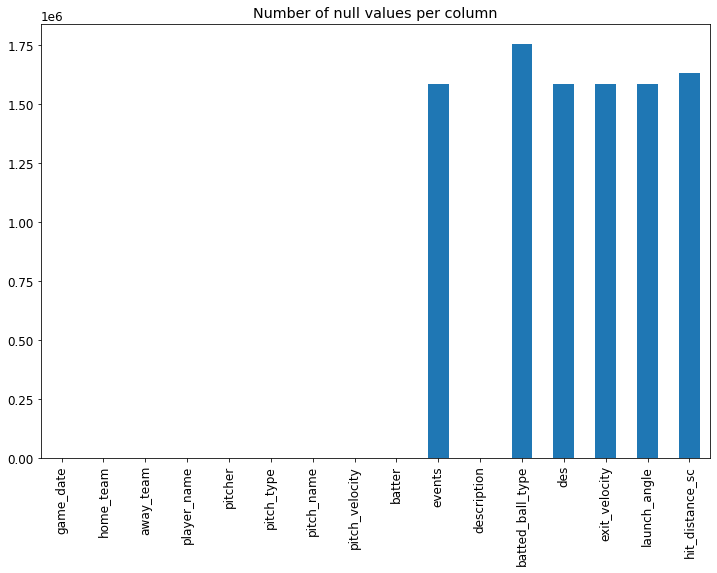

In [17]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar();
plt.title('Number of null values per column');

#### Approach for excluding records:

Each record represents an interaction between a pitcher and a batter (i.e., a pitch thrown by the pitcher to the batter).  The goal is to keep any interaction for which Statcast could provide valid measurements for the metrics `launch_speed`, `launch_angle`, and `hit_distance_sc`.

In order to do so, non-batted ball records will be excluded. <br>

- Drop all `events` = NaN which represent interactions where the batter did not make contact with the ball or the batter made contact with the ball but it was hit foul (e.g., ball, foul, called strike, swinging strike, blocked ball, foul tip, intentional ball, foul bunt, swinging strike blocked, missed bunt, pitchout)

- Drop all `batted_ball_type` = NaN which represents other remaining events where there was not a batted ball (e.g., strikeout, walk, hit by pitch, intentional walk, caught stealing, etc.)

#### Examine `events` column for missingness.

In [18]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
def value_counts_func(df, var, bar, title=''):
    value_counts = df[var].value_counts(dropna=False)
    value_percents = round(df[var].value_counts(normalize=True, dropna=False)*100, 2)
    df_ = pd.DataFrame({'counts': value_counts, 'percentage': value_percents}).rename_axis(var).reset_index()
    
    if bar:
        # Create a vertical bar plot
        # Note: figsize: a tuple (width, height) in inches
        #       rot: rotation for ticks (xticks for vertical, yticks for horizontal plots)
        percents = df[var].value_counts(normalize=True, dropna=False)*100
        ax = percents.plot(kind='bar', figsize=(10, 6), rot=0);
        ax.set_title(title);
        ax.set_ylabel('Percentage');

    format_dict = {'percentage': '{:.2f}'}
    return df_.style.format(format_dict).hide_index()

In [19]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'events', bar=False)

events,counts,percentage
nan,1586052,74.12
field_out,223381,10.44
strikeout,116120,5.43
single,82491,3.85
walk,42138,1.97
double,24898,1.16
home_run,16629,0.78
force_out,11500,0.54
grounded_into_double_play,11266,0.53
hit_by_pitch,5019,0.23


In [20]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#all_MLB_teams2015_2017_new.events.isna() # alias of isnull()
null_events = all_MLB_teams2015_2017_new.events.isnull()
all_MLB_teams2015_2017_new[null_events]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.6,"572,761.0",NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.4,"572,761.0",NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,94.8,"572,761.0",NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,91.6,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,"452,657.0",CU,Curveball,75.9,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",FF,4-Seam Fastball,96.0,"595,885.0",NaN,called_strike,NaN,NaN,NaN,NaN,NaN
4,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",FT,2-Seam Fastball,95.9,"595,885.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
3,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",CH,Changeup,82.8,"595,885.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
2,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",FF,4-Seam Fastball,94.7,"595,885.0",NaN,ball,NaN,NaN,75.0,-7.6433,20.0


#### What types of interactions occurred for missing `events`?

In [21]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new[null_events], 'description', bar=False)

description,counts,percentage
ball,676751,42.67
foul,371731,23.44
called_strike,333190,21.01
swinging_strike,131229,8.27
blocked_ball,45367,2.86
foul_tip,10704,0.67
foul_bunt,6228,0.39
intent_ball,4724,0.30
swinging_strike_blocked,4312,0.27
missed_bunt,1299,0.08


#### Drop missing values from `events` column.

In [22]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['events'], inplace=True)

#### Examine `batted_ball_type` column for missingness.

batted_ball_type,counts,percentage
ground_ball,178646,32.25
nan,166927,30.14
line_drive,99714,18.00
fly_ball,81752,14.76
popup,26829,4.84


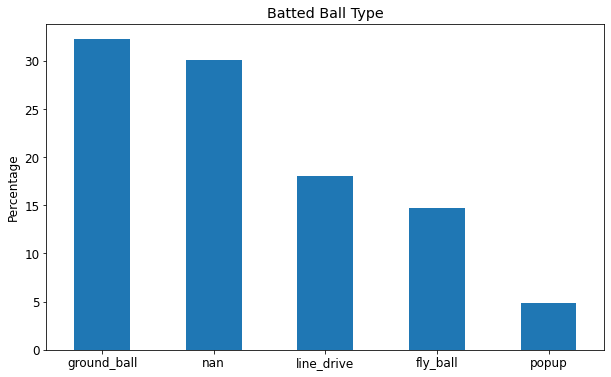

In [23]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'batted_ball_type', bar=True, title='Batted Ball Type')

In [24]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#all_MLB_teams2015_2017_new.batted_ball_type.isna() # alias of isnull()
null_batted_ball_type = all_MLB_teams2015_2017_new.batted_ball_type.isnull()
all_MLB_teams2015_2017_new[null_batted_ball_type]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139906,2015-04-05,CHC,STL,Jon Lester,"452,657.0",CU,Curveball,76.8,"425,509.0",strikeout,swinging_strike,NaN,Jhonny Peralta strikes out swinging.,NaN,NaN,NaN
2139901,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FC,Cutter,89.9,"571,431.0",strikeout,swinging_strike,NaN,Matt Adams strikes out swinging.,NaN,NaN,NaN
2139890,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,84.9,"519,203.0",strikeout,called_strike,NaN,Anthony Rizzo called out on strikes.,NaN,NaN,NaN
2139882,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,92.0,"425,877.0",strikeout,swinging_strike,NaN,Yadier Molina strikes out swinging.,NaN,NaN,NaN
2139875,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,89.6,"543,939.0",walk,ball,NaN,Kolten Wong walks.,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,2017-10-01,NYY,TOR,Domingo German,"593,334.0",FF,4-Seam Fastball,97.0,"606,192.0",strikeout,swinging_strike,NaN,Teoscar Hernandez strikes out swinging.,NaN,NaN,NaN
44,2017-10-01,NYY,TOR,Ryan Tepera,"572,193.0",FC,Cutter,88.9,"592,122.0",strikeout,swinging_strike,NaN,Tyler Austin strikes out swinging.,NaN,NaN,NaN
38,2017-10-01,NYY,TOR,Ryan Tepera,"572,193.0",FC,Cutter,89.5,"543,305.0",strikeout,swinging_strike,NaN,Aaron Hicks strikes out swinging.,NaN,NaN,NaN
29,2017-10-01,NYY,TOR,Ben Heller,"621,294.0",CU,Curveball,82.8,"620,446.0",strikeout,swinging_strike,NaN,Richard Urena strikes out swinging.,NaN,NaN,NaN


#### What types of `events` occurred for missing `batted_ball_type`?

In [25]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new[null_batted_ball_type], 'events', bar=False)

events,counts,percentage
strikeout,116120,69.56
walk,42138,25.24
hit_by_pitch,5019,3.01
intent_walk,1884,1.13
caught_stealing_2b,696,0.42
strikeout_double_play,435,0.26
pickoff_caught_stealing_2b,131,0.08
other_out,120,0.07
catcher_interf,113,0.07
pickoff_1b,95,0.06


#### Drop missing values from `batted_ball_type` column.

In [26]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['batted_ball_type'], inplace=True)

#### Confirm whether the values for `events` and `batted_ball_type` are valid (i.e., values could provide valid measurements for Statcast metrics).

In [27]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'events', bar=False)

events,counts,percentage
field_out,223381,57.73
single,82491,21.32
double,24898,6.43
home_run,16629,4.30
force_out,11500,2.97
grounded_into_double_play,11266,2.91
field_error,4816,1.24
sac_fly,3549,0.92
sac_bunt,3149,0.81
triple,2607,0.67


batted_ball_type,counts,percentage
ground_ball,178646,46.17
line_drive,99714,25.77
fly_ball,81752,21.13
popup,26829,6.93


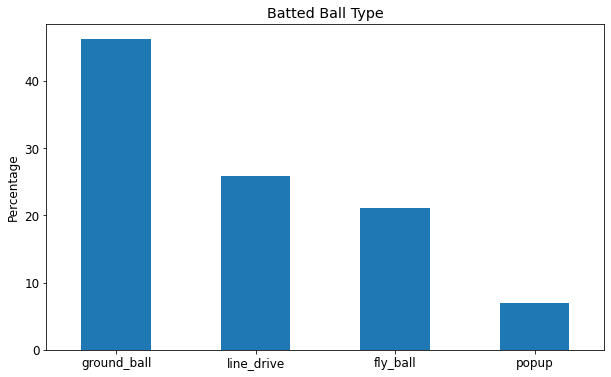

In [28]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'batted_ball_type', bar=True, title='Batted Ball Type')

In [29]:
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False).sum()

386941

In [30]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(all_MLB_teams2015_2017_new.events.fillna(' NaN'), all_MLB_teams2015_2017_new.batted_ball_type.fillna(' NaN'), margins=True, margins_name='Total', dropna=False).style.background_gradient(cmap=orange)

batted_ball_type,fly_ball,ground_ball,line_drive,popup,Total
events,,,,,
double,3502,3342,17914,140,24898
double_play,222,109,930,87,1348
field_error,159,4349,199,109,4816
field_out,60230,103445,33726,25980,223381
fielders_choice,0,301,0,0,301
fielders_choice_out,0,914,2,3,919
force_out,47,11342,74,37,11500
grounded_into_double_play,0,11266,0,0,11266
home_run,11547,0,5082,0,16629


Note: The above frequencies confirm valid values.

In [31]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
null_counts = all_MLB_teams2015_2017_new.isnull().sum()
total_counts = all_MLB_teams2015_2017_new.isnull().count()
missing_percentage = round(null_counts/total_counts*100, 2)
missing_df = pd.DataFrame({'null_count': null_counts, 'percentage': missing_percentage})
missing_df[missing_df.null_count > 0]

,null_count,percentage
pitch_type,701,0.18
pitch_name,701,0.18
pitch_velocity,459,0.12
des,2,0.0
exit_velocity,66,0.02
launch_angle,66,0.02
hit_distance_sc,46472,12.01


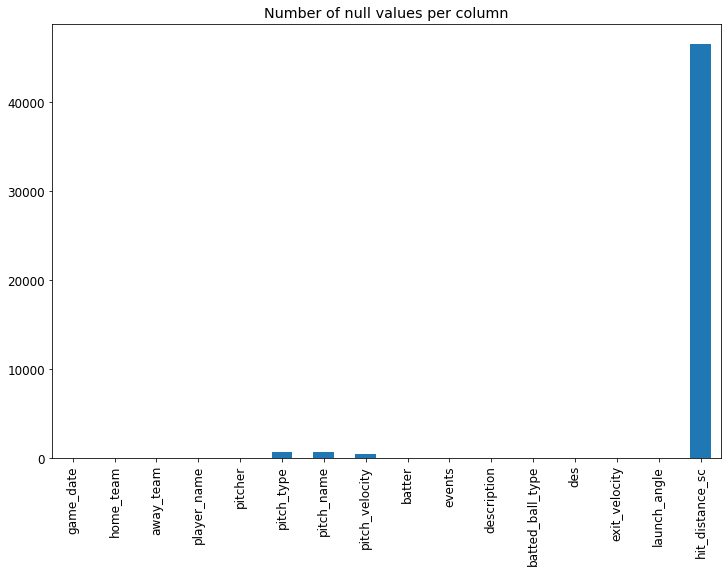

In [32]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar();
plt.title('Number of null values per column');

Note: There are still missing values for the following variables: `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle`. These variables will be used in the modeling and observations with missing values will be dropped.

#### Drop missing values from `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle` columns.

In [33]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['pitch_name', 'pitch_velocity', 'exit_velocity', 'launch_angle'], inplace=True)

### Summarize the DataFrame

In [34]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).describe()

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc
count,"386,112.0","386,112.0","386,112.0","340,221.0"
mean,88.93805243038103,87.22838710008553,10.662181007583529,170.44668024607535
std,5.809725964258756,14.532314679064466,27.245970801318958,136.70036724975247
min,41.5,5.2,-88.89,0.0
25%,85.1,80.0,-8.987,22.0
50%,90.3,89.3,10.605,169.0
75%,93.3,98.1,28.520775,294.0
max,105.4,123.4,89.85,504.0


In [35]:
# Describe object columns (e.g. categorical, strings, or timestamps)
# Generates descriptive summary statistics of the count, unique values, top values, and frequency
# Note: "top" is the most common value; "freq" is the most common value's frequency
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['home_team', 'away_team', 'player_name', 'des'], axis=1).describe(include='object')

,game_date,pitch_type,pitch_name,events,description,batted_ball_type
count,386112,386112,386112,386112,386112,386112
unique,537,16,16,16,4,4
top,2015-09-30,FF,4-Seam Fastball,field_out,hit_into_play,ground_ball
freq,974,131254,131254,222928,249245,178259


In [36]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(all_MLB_teams2015_2017_new.pitch_name.fillna(' NaN'), all_MLB_teams2015_2017_new.pitch_type.fillna(' NaN'), margins=True, margins_name='Total', dropna=False).style.background_gradient(cmap=orange)

pitch_type,CH,CU,EP,FA,FC,FF,FO,FS,FT,KC,KN,PO,SC,SI,SL,UN,Total
pitch_name,,,,,,,,,,,,,,,,,
2-Seam Fastball,0,0,0,0,0,0,0,0,59444,0,0,0,0,0,0,0,59444
4-Seam Fastball,0,0,0,0,0,131254,0,0,0,0,0,0,0,0,0,0,131254
Changeup,43883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43883
Curveball,0,26046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26046
Cutter,0,0,0,0,21484,0,0,0,0,0,0,0,0,0,0,0,21484
Eephus,0,0,114,0,0,0,0,0,0,0,0,0,0,0,0,0,114
Fastball,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3
Forkball,0,0,0,0,0,0,126,0,0,0,0,0,0,0,0,0,126
Knuckle Ball,0,0,0,0,0,0,0,0,0,0,2094,0,0,0,0,0,2094


#### Drop low frequency `pitch_name` observations

In [37]:
# Return elements, either from `x` or `y`, depending on `condition`
all_MLB_teams2015_2017_new['pitch_name_low_freq'] = np.where(all_MLB_teams2015_2017_new.pitch_name.isin(['Eephus', 'Fastball', 'Forkball', 'Pitch Out', 'Screwball', 'Unknown']), 1, 0)

pitch_name_low_freq,counts,percentage
0,385848,99.93
1,264,0.07


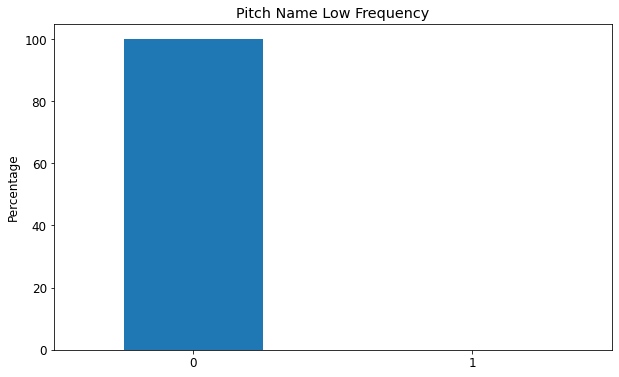

In [38]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'pitch_name_low_freq', bar=True, title='Pitch Name Low Frequency')

In [39]:
# Excluding low frequency values
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new[all_MLB_teams2015_2017_new.pitch_name_low_freq == 0]
all_MLB_teams2015_2017_new.drop('pitch_name_low_freq', axis=1, inplace=True)

In [40]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 385848, Cols: 16


In [41]:
# Calculate the correlation matrix using the default method (Pearson correlation)
baseball_correlations = all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).corr(method='pearson')
round(baseball_correlations, 3)

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc
pitch_velocity,1.0,0.079,0.007,0.017
exit_velocity,0.079,1.0,0.187,0.352
launch_angle,0.007,0.187,1.0,0.733
hit_distance_sc,0.017,0.352,0.733,1.0


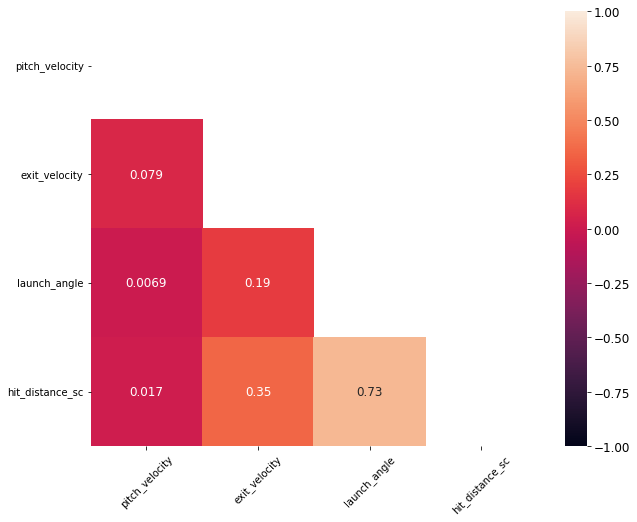

In [42]:
# Create a figure and a set of subplots
# Note: figsize: a tuple (width, height) in inches
fig, ax = plt.subplots(figsize=(10, 8));

# Return an array of zeros with the same shape and type as a given array
mask = np.zeros_like(baseball_correlations, dtype=np.bool)
# Return the indices for the upper-triangle of array
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix (color-encoded) using Seaborn's .heatmap() function
# Note: vmin, vmax: values to anchor the colormap, otherwise they are inferred from the data & other keyword arguments
#       annot: write the data value in each cell
ax = sns.heatmap(baseball_correlations, vmin=-1, vmax=1, annot=True, mask=mask, ax=ax);

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, rotation=45);
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va='center', rotation=0);

plt.show();

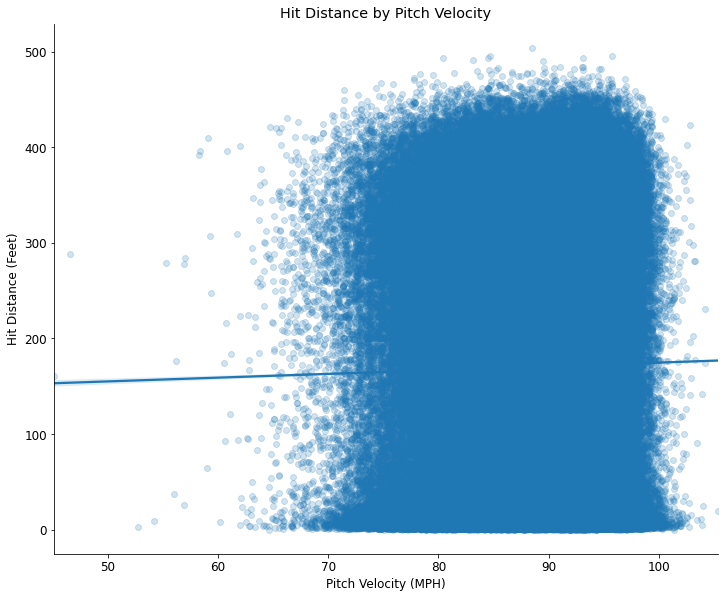

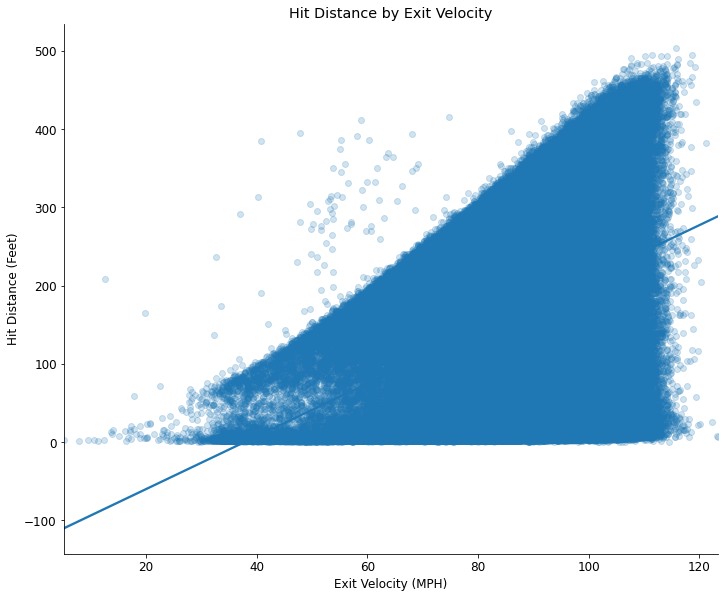

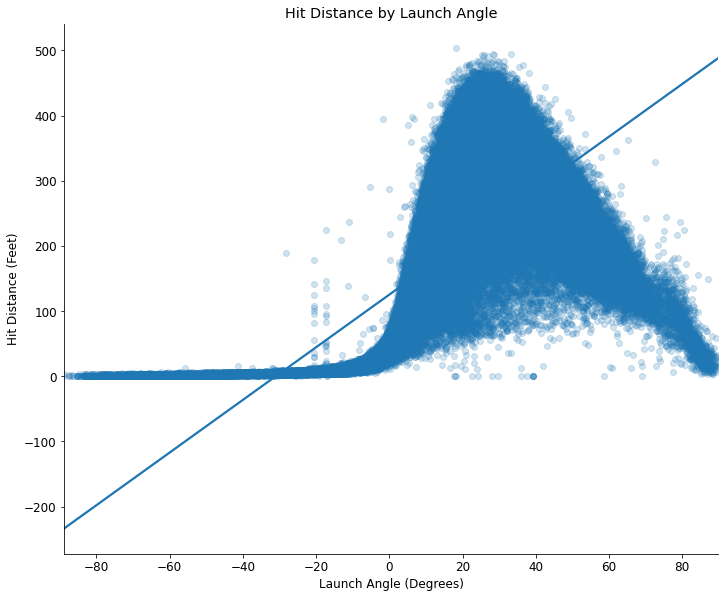

In [43]:
# Plot a simple linear relationship between two variables using Seaborn scatterplot with regression line
# Note: data: DataFrame name
#       fit_reg=True estimates and plots a regression model relating the x and y variables
#       size: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that "aspect * size" gives the width of each facet in inches
#       scatter_kws=alpha: blending value, between 0 (transparent) and 1 (opaque)
sns.lmplot(x='pitch_velocity', y='hit_distance_sc', data=all_MLB_teams2015_2017_new, fit_reg=True, height=8, aspect=10/8, scatter_kws={'alpha':0.2});
plt.xlabel('Pitch Velocity (MPH)');
plt.ylabel('Hit Distance (Feet)');
plt.title('Hit Distance by Pitch Velocity');
plt.show()
sns.lmplot(x='exit_velocity', y='hit_distance_sc', data=all_MLB_teams2015_2017_new, fit_reg=True, height=8, aspect=10/8, scatter_kws={'alpha':0.2});
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Hit Distance (Feet)');
plt.title('Hit Distance by Exit Velocity');
plt.show()
sns.lmplot(x='launch_angle', y='hit_distance_sc', data=all_MLB_teams2015_2017_new, fit_reg=True, height=8, aspect=10/8, scatter_kws={'alpha':0.2});
plt.xlabel('Launch Angle (Degrees)');
plt.ylabel('Hit Distance (Feet)');
plt.title('Hit Distance by Launch Angle');

In [44]:
# Create feature column variables
feature_cols = ['pitch_velocity', 'exit_velocity', 'launch_angle']

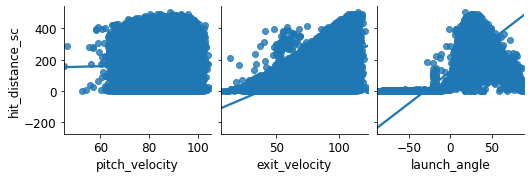

In [45]:
# Plot pairwise relationships (scatterplots for joint relationships) using Seaborn's .pairplot() function
# Note: kind: kind of plot for the non-identity relationships ('scatter' or 'reg')
sns.pairplot(all_MLB_teams2015_2017_new, x_vars=feature_cols, y_vars='hit_distance_sc', kind='reg');

In [46]:
# For each pitch name group, describe hit distance:
all_MLB_teams2015_2017_new.groupby(by='pitch_name').hit_distance_sc.describe()

,count,mean,std,min,25%,50%,75%,max
pitch_name,,,,,,,,
2-Seam Fastball,"52,265.0",153.44775662489238,137.37679837349785,0.0,14.0,125.0,281.0,493.0
4-Seam Fastball,"116,587.0",191.58778422980265,134.70236622179894,0.0,44.0,209.0,309.0,495.0
Changeup,"38,322.0",160.1829236469913,136.71519955605467,0.0,17.0,147.0,285.0,504.0
Curveball,"23,077.0",162.5189582701391,134.34749814601716,0.0,21.0,152.0,285.0,479.0
Cutter,"18,945.0",167.30329902348905,134.80569397841447,0.0,23.0,162.0,287.0,491.0
Knuckle Ball,"1,841.0",168.9228680065182,137.44151927760134,1.0,19.0,165.0,296.0,477.0
Knuckle Curve,"6,555.0",144.75194508009153,133.65453161408166,0.0,14.0,108.0,266.5,463.0
Sinker,"28,877.0",150.9022059078159,137.648595905495,0.0,13.0,118.0,279.0,478.0
Slider,"48,085.0",168.3382759696371,135.43507578845697,0.0,22.0,166.0,289.0,495.0


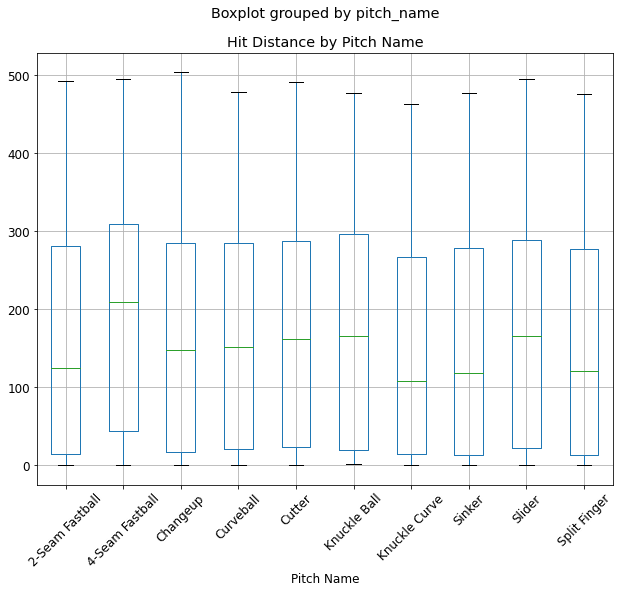

In [47]:
# Create box plots
# Note: column: used to limit data to a subset of columns
#       by: used to form box plots for separate groups
#       rot: rotation angle of labels (in degrees) with respect to the screen coordinate sytem
#       figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.boxplot(column='hit_distance_sc', by='pitch_name', rot=45, figsize=(10, 8));
plt.xlabel('Pitch Name');
plt.title('Hit Distance by Pitch Name');

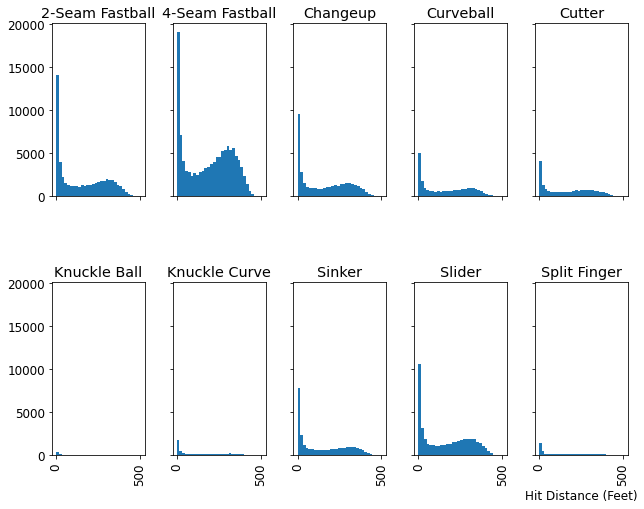

In [48]:
# Create histograms
# Note: column: used to limit data to a subset of columns
#       by: used to form histograms for separate groups
#       sharex: share x axis and set some x axis labels to invisible
#       sharey: share y axis and set some y axis labels to invisible
#       layout: tuple of (rows, columns) for the layout of the histograms
#       figsize: a tuple (width, height) in inches
#       bins: number of histogram bins to be used
all_MLB_teams2015_2017_new.hist(column='hit_distance_sc', by='pitch_name', sharex=True, sharey=True, layout=(2, 5), figsize=(10, 8), bins=30);
plt.xlabel('Hit Distance (Feet)');
plt.ylabel('Frequency');

### Data Modeling

### Using Random Forests for Regression

#### Build and train random forest regression model

Note: <br>
- `RandomForestRegressor` does not support missing values for targets.
- Categorical predictor variables must be converted to numeric variables with integer values in order to use `RandomForestRegressor`.

In [49]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
null_counts = all_MLB_teams2015_2017_new.isnull().sum()
total_counts = all_MLB_teams2015_2017_new.isnull().count()
missing_percentage = round(null_counts/total_counts*100, 2)
missing_df = pd.DataFrame({'null_count': null_counts, 'percentage': missing_percentage})
missing_df[missing_df.null_count > 0]

,null_count,percentage
des,2,0.0
hit_distance_sc,45864,11.89


Drop missing values from `hit_distance_sc` column.

In [50]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['hit_distance_sc'], inplace=True)

Create dummy variables for `pitch_name`.

In [51]:
# Convert categorical variable into dummy/indicator variables
# Note: prefix: string to append DataFrame column names
#       drop_first=True removes the first level to get k-1 dummies out of k categorical events
# Join columns with other DataFrame either on index or on a key
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.join(pd.get_dummies(all_MLB_teams2015_2017_new.pitch_name, prefix='pitch_name', drop_first=True))
all_MLB_teams2015_2017_new.head()

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,...,hit_distance_sc,pitch_name_4-Seam Fastball,pitch_name_Changeup,pitch_name_Curveball,pitch_name_Cutter,pitch_name_Knuckle Ball,pitch_name_Knuckle Curve,pitch_name_Sinker,pitch_name_Slider,pitch_name_Split Finger
2139899,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,88.1,"451,594.0",double,...,209.0,0,0,0,1,0,0,0,0,0
2139886,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,88.1,"516,770.0",field_out,...,12.0,0,0,0,1,0,0,0,0,0
2139865,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FC,Cutter,88.1,"572,761.0",single,...,189.0,0,0,0,1,0,0,0,0,0
2139861,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,87.8,"458,085.0",double,...,260.0,0,0,0,1,0,0,0,0,0
2139852,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FF,4-Seam Fastball,89.8,"424,325.0",field_out,...,364.0,1,0,0,0,0,0,0,0,0


### Building Phase

#### Predicting Hit Distance 

In [52]:
# # Create a list of features
# feature_cols = ['pitch_velocity', 'exit_velocity', 'launch_angle',
#                 'pitch_name_4-Seam Fastball', 'pitch_name_Changeup', 'pitch_name_Curveball', 'pitch_name_Cutter',
#                 'pitch_name_Knuckle Ball', 'pitch_name_Knuckle Curve', 'pitch_name_Sinker', 'pitch_name_Slider', 'pitch_name_Split Finger']

In [53]:
feature_cols = ['pitch_velocity', 'exit_velocity', 'launch_angle', 'pitch_name']

In [54]:
# Create X and y
X = all_MLB_teams2015_2017_new[feature_cols]
y = all_MLB_teams2015_2017_new.hit_distance_sc

In [55]:
# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=65)

print('Length of X_train: {}'.format(len(X_train)))
print('Length of y_train: {}'.format(len(y_train)))
print('Length of X_test: {}'.format(len(X_test)))
print('Length of y_test: {}'.format(len(y_test)))

Length of X_train: 237988
Length of y_train: 237988
Length of X_test: 101996
Length of y_test: 101996


#### Compute Baseline (Null) RMSE
[How to Get Baseline Results and Why They Matter](https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/)

Note: Using a null model (i.e., using the mean value for the prediction). <br>

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [56]:
# Create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_train
y_null.fill(y_train.mean())
print(y_null)
print()

# Mean squared error (MSE) regression loss
print('Baseline (Null) MSE:', round(metrics.mean_squared_error(y_test, y_null), 3))

# Root mean squared error (RMSE) regression loss
print('Baseline (Null) RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_null)), 3))
print()

# Instantiate a regressor that makes predictions using simple rules and fit dummy regressor
# Note: stragegy: strategy to use to generate predictions
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)
y_pred = dummy_reg.predict(X_test)

# Mean squared error (MSE) regression loss
print('Baseline (Null) MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

# Root mean squared error (RMSE) regression loss
print('Baseline (Null) RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))

[170.17825269 170.17825269 170.17825269 ... 170.17825269 170.17825269
 170.17825269]

Baseline (Null) MSE: 18699.423
Baseline (Null) RMSE: 136.746

Baseline (Null) MSE: 18699.423
Baseline (Null) RMSE: 136.746


Note: Creating train/test as arrays for purpose of running code below: 'Understanding the decision tree structure'. DataFrames do not work for this code.

In [57]:
X_train_array = X_train.values
X_test_array = X_test.values
y_train_array = y_train.values
y_test_array = y_test.values

### Incorporate data preprocessing and model estimator into a pipeline
#### _Data Preprocessing_
- **Scaling Numerical Features:** Scaling numerical features (e.g., using `StandardScaler`) is a standard preprocessing step to improve the training process for machine learning models. It is performed to ensure that all numerical features have similar scales. It helps the optimization process during training and prevents features with larger scales from dominating the learning process. However, this scaling process only affects the numerical features. It does not impact the coefficients of non-numerical (categorical) features. The coefficients for categorical features are determined based on the unique categories or levels of those features and remain unchanged by the scaling of numerical features.
- **Encoding Categorical Features:** Before using categorical features in a machine learning model, you typically need to encode them into a numeric format. Common encoding techniques include one-hot encoding (for nominal features) and ordinal encoding (for ordinal features). These encoding methods create binary or integer columns to represent the categories, and these encoded features do not require scaling.

Machine learning algorithms that rely on distance-based calculations or gradient-based optimization typically require numeric features to be scaled. Scaling ensures that all features have similar scales and magnitudes, which can improve the performance and convergence of these algorithms. Here are some machine learning algorithms that commonly benefit from feature scaling:

1. **K-Nearest Neighbors (KNN):** KNN calculates distances between data points to make predictions. Feature scaling is crucial because larger magnitude features can dominate the distance calculation.

2. **Support Vector Machines (SVM):** SVM aims to find a hyperplane that maximizes the margin between classes. Scaling helps ensure that the margin is not dominated by features with larger scales.

3. **Principal Component Analysis (PCA):** PCA is used for dimensionality reduction. Feature scaling is important because PCA is sensitive to the scales of features.

4. **Gradient-Based Algorithms (e.g., Gradient Descent):** Algorithms like linear regression, logistic regression, neural networks, and many others that use gradient-based optimization techniques benefit from scaled features. Scaling helps the optimization process converge faster and more reliably.

5. **Regularized Models (e.g., Lasso, Ridge, ElasticNet):** These models involve regularization terms that depend on the scale of the coefficients. Scaling features ensures that the regularization terms treat all features equally.

6. **K-Means Clustering:** K-Means calculates cluster centroids based on the mean of data points in each cluster. Scaling helps ensure that all features contribute equally to the cluster centroids.

7. **Hierarchical Clustering:** Similar to K-Means, hierarchical clustering methods can benefit from scaled features when calculating distances between clusters.

8. **Principal Component Regression (PCR):** PCR combines PCA with regression. Scaled features are essential for both PCA and regression components.

9. **Neural Networks:** Deep learning models, including neural networks, often require feature scaling, especially when using activation functions like sigmoid or tanh.

On the other hand, some algorithms are inherently scale-invariant, meaning they don't require feature scaling. These include:

1. **Decision Trees:** Decision trees and ensemble methods based on them (e.g., Random Forests, Gradient Boosting Trees) are not sensitive to feature scales.

2. **Naive Bayes:** Naive Bayes classifiers are not affected by feature scaling since they work with probability distributions.

3. **Tree-Based Models:** Models like decision trees, Random Forests, and XGBoost are invariant to feature scaling because they make decisions based on relative feature ordering.

4. **Rule-Based Models:** Models like association rule mining (e.g., Apriori) and rule-based classifiers (e.g., RIPPER) are not affected by feature scaling.

While scaling is crucial for some algorithms, it's a best practice to perform feature scaling for most machine learning tasks. Scikit-learn provides preprocessing tools like `StandardScaler` and `MinMaxScaler` to easily scale numeric features for various algorithms.

In [58]:
# Define numerical and categorical feature columns

# List of numeric feature column names
numeric_features = ['pitch_velocity', 'exit_velocity', 'launch_angle']

# List of categorical feature column names
categorical_features = ['pitch_name']

In [59]:
# Create preprocessing transformers for numeric and categorical features
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler()) # Scaling for numeric features
# ])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first')) # One-hot encoding for categorical features
])

# Applies transformers to columns of an array or pandas DataFrame
# -> This estimator allows different columns or column subsets of the input to be transformed separately 
#    and the features generated by each transformer will be concatenated to form a single feature space
# -> This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms 
#    or transformations into a single transformer
# Note: transformers: list of (name, transformer, column(s)) tuples specifying the transformer objects 
#                     to be applied to subsets of the data
#       remainder: {'drop', 'passthrough'} or estimator, default 'drop'
#                  By default, only the specified columns in `transformers` are transformed and combined 
#                  in the output, and the non-specified columns are dropped. (default of ``'drop'``).
#                  By specifying remainder='passthrough', all remaining columns that were not specified 
#                  in `transformers` will be automatically passed through. 
#                  This subset of columns is concatenated with the output of the transformers.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features), # Scaling not necessary for tree-based models
        ('cat', categorical_transformer, categorical_features)
    ],
#     remainder='passthrough'
)
preprocessor

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['pitch_velocity', 'exit_velocity',
                                  'launch_angle']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['pitch_name'])])

In [60]:
# Instantiate a random forest regressor
# Note: n_estimators: number of trees in the forest
#       criterion: function to measure the quality of a split; supported criteria are "squared_error" for the 
#                  mean squared error (MSE), which is equal tovariance reduction as feature selection criterion, 
#                  "absolute_error" for the mean absolute error (MAE), and "poisson" which uses reduction in
#                  Poisson deviance to find splits
#       max_depth: maximum depth of the tree; if None, then nodes are expanded until all leaves are pure or 
#                  until all leaves contain less than min_samples_split samples
#       min_samples_leaf: minimum number of samples required to be at a leaf node
#       n_jobs: number of jobs to run in parallel; -1 means using all processors
#       random_state: the seed used by the random number generator
rf_regr = RandomForestRegressor(random_state=46) 

In [61]:
# Create the pipeline with the preprocessor and the regressor
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # Apply preprocessing to features
        ('regressor', rf_regr) # Regressor
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['pitch_name'])])),
                ('regressor', RandomForestRegressor(random_state=46))])

### Operational Phase

In [62]:
# Function to make predictions 
def prediction(X_test, regr_object, model_type_text): 
  
    # Predict using the regression model
    # Note: For a regression model, the predicted value based on X is returned
    y_pred = regr_object.predict(X_test)

    print('Results Using {}:'.format(model_type_text))
    print('Predicted values:')
    print(y_pred)
    print('')
    return y_pred

### $MSE = \frac{\sum_{i=1}^n (y_i-\hat{y})^2}{n}$

### $MAE = \frac{\sum_{i=1}^n \mid y_i-\hat{y} \mid }{n}$

In [63]:
# Function to calculate evaluation metrics
def eval_metrics(y_test, y_pred, regr_object):
    
    print('Training:')
    # Mean squared error (MSE) regression loss
    print('MSE: ', round(metrics.mean_squared_error(y_train, regr_object.predict(X_train)), 3))
    
    # Root mean squared error (RMSE) regression loss
    training_rmse = sqrt(metrics.mean_squared_error(y_train, regr_object.predict(X_train)))
    print('RMSE:', round(training_rmse, 3))
    
    # Mean absolute error (MAE) regression loss
    print('MAE: ', round(metrics.mean_absolute_error(y_train, regr_object.predict(X_train)), 3))
    
    # Coefficient of Determination R^2
    training_r2 = regr_object.score(X_train, y_train)
    print('R\u00b2:', round(training_r2, 3))
    
    # Adjusted R^2
    training_adj_r2 = 1-(1-regr_object.score(X_train, y_train)) * (len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    print('Adjusted R\u00b2:', round(training_adj_r2, 3))
    print('')   
  
    print('Testing:')
    # Mean squared error (MSE) regression loss
    print('MSE: ', round(metrics.mean_squared_error(y_test, y_pred), 3))

    # Root mean squared error (RMSE) regression loss
    testing_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('RMSE:', round(testing_rmse, 3))
    
    # Mean absolute error (MAE) regression loss
    print('MAE: ', round(metrics.mean_absolute_error(y_test, y_pred), 3))
    
    # Coefficient of Determination R^2
    testing_r2 = regr_object.score(X_test, y_test)
    print('R\u00b2:', round(testing_r2, 3))
    
    # Adjusted R^2
    testing_adj_r2 = 1-(1-regr_object.score(X_test, y_test)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print('Adjusted R\u00b2:', round(testing_adj_r2, 3))
    print('') 
    
    if training_rmse < testing_rmse:
        print('Testing RMSE > Training RMSE')
        print('-> Overfitting!')
    else:
        print('Testing RMSE < Training RMSE')
        print('-> Not overfitting')

#### Optimize model using grid-search with cross-validation

In [64]:
# Define the parameter grid for hyperparameter tuning
parameters = {'regressor__n_estimators': [30, 50, 100],
              'regressor__max_depth': [2, 3, 4],
              'regressor__min_samples_leaf': [1, 2, 4]}

pprint(parameters)

{'regressor__max_depth': [2, 3, 4],
 'regressor__min_samples_leaf': [1, 2, 4],
 'regressor__n_estimators': [30, 50, 100]}


#### Perform grid search using Mean Squared Error (MSE) as scoring method

In [65]:
# Instantiate an exhaustive search over specified parameter values for an estimator and run fit with all sets of parameters
# Note: estimator: estimator object
#       param_grid: dictionary with parameters names (string) as keys and lists of parameter settings to try as values; 
#                   this enables searching over any sequence of parameter settings
#       scoring: a single string or a callable to evaluate the predictions on the test set
#       n_jobs: number of jobs to run in parallel; if -1, then the number of jobs is set to the number of cores
#       cv: number of folds in k-fold cross-validation
#       return_train_score: if False, the cv_results_ attribute will not include training scores
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='neg_mean_squared_error',
                           n_jobs=-1, cv=5, return_train_score=True)
search_time_start = time.time()
grid_search.fit(X_train, y_train)
print('Grid search time:', int((time.time() - search_time_start)/60), 'mins')

Grid search time: 5 mins


In [66]:
results = pd.DataFrame.from_dict(grid_search.cv_results_)
pd.DataFrame.from_dict(grid_search.cv_results_, orient='index').style.set_sticky(axis='index')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
mean_fit_time,11.106993,18.147851,34.340406,10.441437,17.161610,34.559023,10.606487,17.684183,32.820778,14.542541,24.095879,48.975210,14.496013,24.827001,50.625573,16.180014,25.040690,46.946625,18.776222,29.815214,57.940814,17.540457,29.329271,56.372418,17.802957,28.773674,35.783978
std_fit_time,0.280351,0.194978,0.248825,0.072190,0.340996,0.201586,0.344188,0.237600,0.127237,0.127311,0.108983,0.309054,0.075100,0.124302,0.581628,0.143630,0.473145,0.626601,0.071495,0.453536,0.202355,0.052494,0.112042,1.279905,0.076096,0.526517,4.635529
mean_score_time,0.190491,0.263228,0.408569,0.186710,0.253390,0.425354,0.202882,0.276731,0.421312,0.191714,0.290683,0.567647,0.207879,0.335638,0.487226,0.238182,0.292566,0.480019,0.220402,0.298455,0.509918,0.224644,0.285914,0.406599,0.208758,0.278700,0.206845
std_score_time,0.018084,0.012423,0.005567,0.010342,0.018435,0.022531,0.016194,0.043967,0.006051,0.004729,0.017786,0.071358,0.011552,0.043799,0.031349,0.027908,0.011585,0.021151,0.011754,0.010001,0.018144,0.030381,0.026440,0.089701,0.010857,0.025927,0.028737
param_regressor__max_depth,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4
param_regressor__min_samples_leaf,1,1,1,2,2,2,4,4,4,1,1,1,2,2,2,4,4,4,1,1,1,2,2,2,4,4,4
param_regressor__n_estimators,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100
params,"{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 30}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 30}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 50}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 100}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 30}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 50}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 100}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 30}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 30}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 50}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 100}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 30}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 50}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 100}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 30}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 30}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 50}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 100}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 30}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 50}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 100}"
s

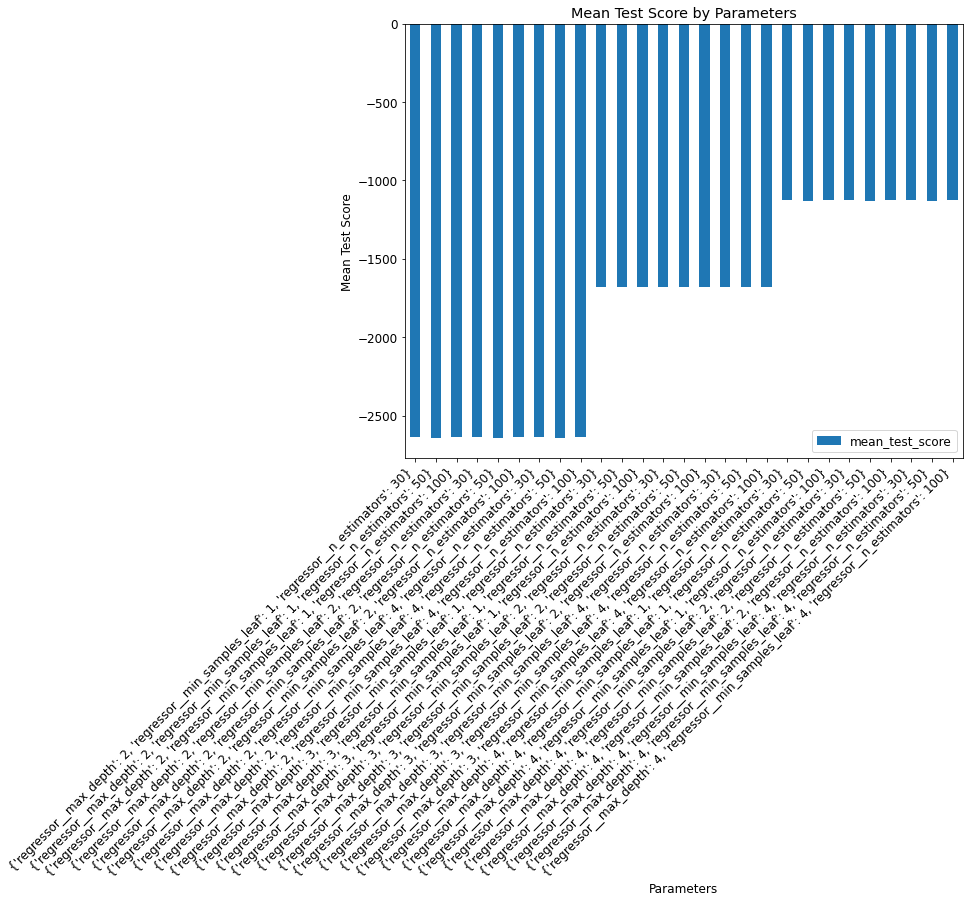

In [67]:
# Create a vertical bar plot by mean test score using matplotlib
# Note: figsize: a tuple (width, height) in inches
ax = results.plot.bar(y='mean_test_score', x='params', figsize=(10, 8));
ax.set_xticklabels(results.params, rotation=45, horizontalalignment='right');
plt.xlabel('Parameters');
plt.ylabel('Mean Test Score');
plt.title('Mean Test Score by Parameters');

In [68]:
print('Best parameter setting found by grid search:')
print(grid_search.best_params_)
print()
print('Best mean cross-validated score found by grid search:')
# Best score will be the highest of the negated scores (MSEs or MAEs), which is equal to the lowest actual score
best_neg_score = grid_search.best_score_
best_score = -best_neg_score  # Convert back to positive score for interpretation
print(round(best_score, 3))
print()
print('Scorer function used on the held out data to choose the best parameters for the model:')
print(grid_search.scorer_)

Best parameter setting found by grid search:
{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 30}

Best mean cross-validated score found by grid search:
1127.344

Scorer function used on the held out data to choose the best parameters for the model:
make_scorer(mean_squared_error, greater_is_better=False)


#### Prediction using Decision Tree Model with MSE criteria and Cross-Validation

Calculate both the MSE and the MAE on the test data using the `best_estimator_` obtained from `GridSearchCV`, even if the chosen scoring method during the grid search was MSE.

1. **Different Aspects of Model Performance**: MSE and MAE measure different aspects of the errors in your predictions. MSE gives more weight to larger errors (since the errors are squared), which might be important if large errors are particularly undesirable in your context. MAE, on the other hand, provides a more intuitive measure of average error magnitude.
2. **Comprehensive Evaluation**: Evaluating your model on multiple metrics provides a more comprehensive view of its performance. While `GridSearchCV` optimizes for one metric (MSE in this case), this doesn't mean that other metrics are not useful or informative.
3. **Robustness and Interpretability**: MAE can be particularly useful because it is less sensitive to outliers than MSE. In many practical scenarios, understanding both the typical error (MAE) and the error distribution (MSE) can lead to better decision-making and model interpretation.
4. **Consistency Across Data Splits**: It's perfectly valid to use different metrics for model selection (during training) and model evaluation (on test data). The goal during training is to find the best model parameters (which you did using MSE), but when evaluating the model's performance, you want to understand its behavior as comprehensively as possible.

In [69]:
model_type_text='Decision Tree Model with MSE Criteria and Cross-Validation'
y_pred_dt_regr_grid_search_mse = prediction(X_test, grid_search.best_estimator_, model_type_text)
eval_metrics(y_test, y_pred_dt_regr_grid_search_mse, grid_search.best_estimator_)

Results Using Decision Tree Model with MSE Criteria and Cross-Validation:
Predicted values:
[344.81903443 236.79176353 247.68488536 ...  17.75716929 101.43151548
 247.68488536]

Training:
MSE:  1132.99
RMSE: 33.66
MAE:  22.346
R²: 0.939
Adjusted R²: 0.939

Testing:
MSE:  1143.192
RMSE: 33.811
MAE:  22.43
R²: 0.939
Adjusted R²: 0.939

Testing RMSE > Training RMSE
-> Overfitting!


#### Perform grid search using MAE as scoring method

In [70]:
# Instantiate an exhaustive search over specified parameter values for an estimator and run fit with all sets of parameters
# Note: estimator: estimator object
#       param_grid: dictionary with parameters names (string) as keys and lists of parameter settings to try as values; 
#                   this enables searching over any sequence of parameter settings
#       scoring: a single string or a callable to evaluate the predictions on the test set
#       n_jobs: number of jobs to run in parallel; if -1, then the number of jobs is set to the number of cores
#       cv: number of folds in k-fold cross-validation
#       return_train_score: if False, the cv_results_ attribute will not include training scores
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='neg_mean_absolute_error',
                           n_jobs=-1, cv=5, return_train_score=True)
search_time_start = time.time()
grid_search.fit(X_train, y_train)
print('Grid search time:', int((time.time() - search_time_start)/60), 'mins')

Grid search time: 5 mins


In [71]:
results = pd.DataFrame.from_dict(grid_search.cv_results_)
pd.DataFrame.from_dict(grid_search.cv_results_, orient='index').style.set_sticky(axis='index')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
mean_fit_time,8.930341,16.634668,32.059189,10.001218,15.842591,31.650908,9.603164,16.256767,31.434817,13.894290,22.785715,45.011773,13.747747,22.828091,44.925533,13.709668,22.831263,46.206967,18.768480,29.938728,57.996958,17.553669,29.265740,58.808313,17.873189,30.905593,40.387582
std_fit_time,0.341725,0.093188,0.110547,0.285534,0.148683,0.219032,0.071796,0.074469,0.206975,0.143468,0.142609,0.232070,0.055363,0.112318,0.174194,0.159064,0.028462,0.220425,0.195071,0.644887,0.187320,0.054211,0.170185,0.168169,0.157251,0.341597,5.200743
mean_score_time,0.166965,0.220805,0.404344,0.171283,0.242684,0.393775,0.200296,0.268235,0.404468,0.196701,0.272385,0.450169,0.190912,0.265611,0.472395,0.192549,0.271851,0.467897,0.219069,0.292921,0.497687,0.211360,0.281868,0.444125,0.213455,0.299166,0.234187
std_score_time,0.012791,0.011232,0.010022,0.010450,0.011403,0.016695,0.042895,0.036329,0.029087,0.008940,0.009277,0.017936,0.013378,0.015379,0.011348,0.007808,0.009789,0.016800,0.013034,0.011461,0.016389,0.013632,0.018228,0.086511,0.017312,0.018061,0.035559
param_regressor__max_depth,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4
param_regressor__min_samples_leaf,1,1,1,2,2,2,4,4,4,1,1,1,2,2,2,4,4,4,1,1,1,2,2,2,4,4,4
param_regressor__n_estimators,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100
params,"{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 30}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 30}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 50}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 100}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 30}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 50}","{'regressor__max_depth': 2, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 100}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 30}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 30}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 50}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 100}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 30}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 50}","{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 100}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 30}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 30}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 50}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 100}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 30}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 50}","{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 100}"
spl

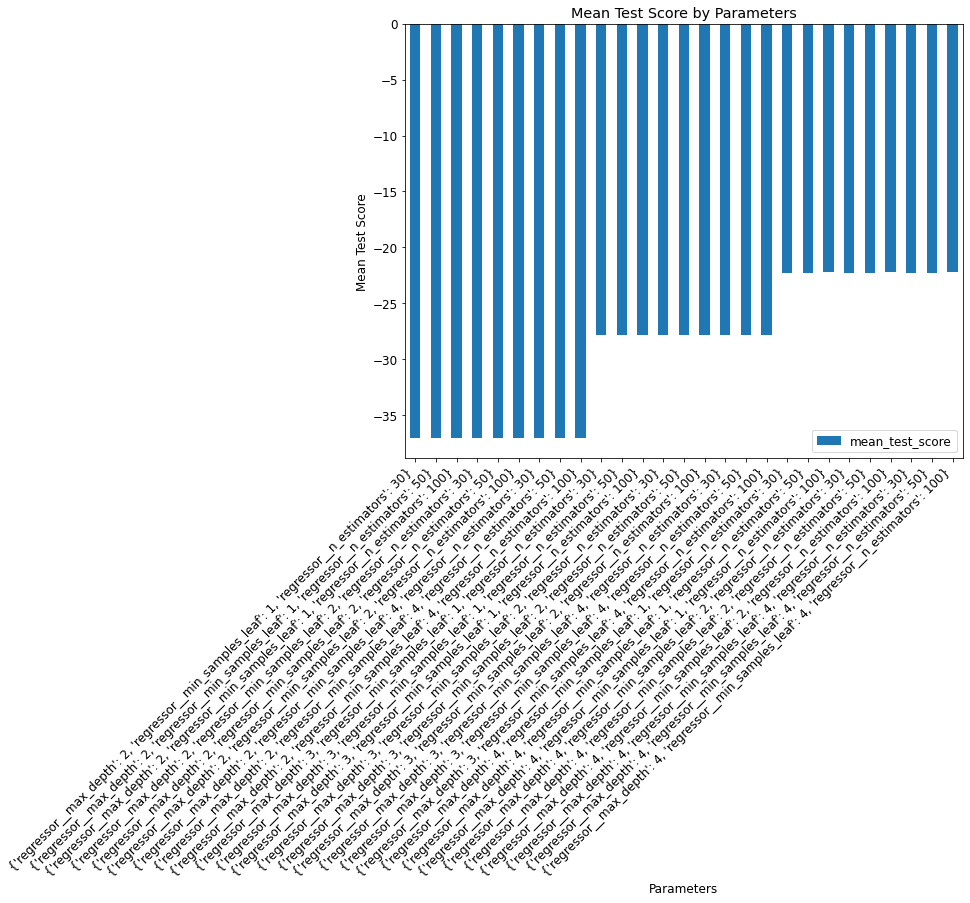

In [72]:
# Create a vertical bar plot by mean test score using matplotlib
# Note: figsize: a tuple (width, height) in inches
ax = results.plot.bar(y='mean_test_score', x='params', figsize=(10, 8));
ax.set_xticklabels(results.params, rotation=45, horizontalalignment='right');
plt.xlabel('Parameters');
plt.ylabel('Mean Test Score');
plt.title('Mean Test Score by Parameters');

In [73]:
print('Best parameter setting found by grid search:')
print(grid_search.best_params_)
print()
print('Best mean cross-validated score found by grid search:')
# Best score will be the highest of the negated scores (MSEs or MAEs), which is equal to the lowest actual score
best_neg_score = grid_search.best_score_
best_score = -best_neg_score  # Convert back to positive score for interpretation
print(round(best_score, 3))
print()
print('Scorer function used on the held out data to choose the best parameters for the model:')
print(grid_search.scorer_)

Best parameter setting found by grid search:
{'regressor__max_depth': 4, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}

Best mean cross-validated score found by grid search:
22.236

Scorer function used on the held out data to choose the best parameters for the model:
make_scorer(mean_absolute_error, greater_is_better=False)


#### Prediction using Decision Tree Model with MAE criteria and Cross-Validation

Calculate both the MSE and the MAE on the test data using the `best_estimator_` obtained from `GridSearchCV`, even if the chosen scoring method during the grid search was MAE.

1. **Different Aspects of Model Performance**: MSE and MAE measure different aspects of the errors in your predictions. MSE gives more weight to larger errors (since the errors are squared), which might be important if large errors are particularly undesirable in your context. MAE, on the other hand, provides a more intuitive measure of average error magnitude.
2. **Comprehensive Evaluation**: Evaluating your model on multiple metrics provides a more comprehensive view of its performance. While `GridSearchCV` optimizes for one metric (MAE in this case), this doesn't mean that other metrics are not useful or informative.
3. **Robustness and Interpretability**: MAE can be particularly useful because it is less sensitive to outliers than MSE. In many practical scenarios, understanding both the typical error (MAE) and the error distribution (MSE) can lead to better decision-making and model interpretation.
4. **Consistency Across Data Splits**: It's perfectly valid to use different metrics for model selection (during training) and model evaluation (on test data). The goal during training is to find the best model parameters (which you did using MAE), but when evaluating the model's performance, you want to understand its behavior as comprehensively as possible.

In [74]:
model_type_text='Decision Tree Model with MAE Criteria and Cross-Validation'
y_pred_dt_regr_grid_search_mae = prediction(X_test, grid_search.best_estimator_, model_type_text)
eval_metrics(y_test, y_pred_dt_regr_grid_search_mae, grid_search.best_estimator_)

Results Using Decision Tree Model with MAE Criteria and Cross-Validation:
Predicted values:
[344.57460162 236.47745449 247.07701428 ...  17.75862844 101.71802058
 247.07701428]

Training:
MSE:  1138.867
RMSE: 33.747
MAE:  22.393
R²: 0.939
Adjusted R²: 0.939

Testing:
MSE:  1148.657
RMSE: 33.892
MAE:  22.483
R²: 0.939
Adjusted R²: 0.939

Testing RMSE > Training RMSE
-> Overfitting!
